# A simple model of bandpasses, building towards an evaluation of H2O impact

JR, 5/28/2021

In this notebook I build a model of bandpasses "with wings" based on logistic functions, and compare how those bandpasses act on atmospheric spectra, relative to RF-modeled ones sent by Sara Simon.

The goal is to have a band model that is specified by only the center and width, ie wing properties derived from those, so the band shape can be used to do generic explorations of NET, pwv signal, etc as a function of (center, width) only.

In [9]:
# Standard imports
import numpy as np
import h5py as hp
import yaml
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12,6]

In [10]:
# The three sets of dichroic bands from Sara.
filenames = ['LF_filter_OMT.txt','MF_wOMT_wLPF_v1.txt','UHF_wOMT.txt']

In [11]:
# Define two functions used to set up the logistic-function band model

def bandmodel(nuvec, heightsum, nu0, dnu):
    #return flat_model(nuvec,heightsum, nu0, dnu)
    return logistic_model(nuvec,heightsum, nu0, dnu)

def logistic_model(nuvec, band_int, nu0,dnu):
    '''Returns a logistic-function band model given inputs
    
      nuvec:  vector of frequencies at which to return the function
      band_int: the desired integral over the band.
      nu0:  center frequency
      dnu:  bandwidth
      
    '''
    low = nu0-dnu/2
    high = nu0+dnu/2
    # I tuned aa and nn by hand to "best fit by eye" (globally) 
    # the bands Sara provided in the first plot below.
    aa = 2     # smaller aa gives broader tails at all frequency bands
    nn = 0.7   # larger nn gives broader tails at higher frequency bands
    k1 = aa*(20/low)**nn
    f1 = 1/(1+np.exp(-k1*(nuvec-low )))
    k2 = aa*(20/high)**nn
    f2 = 1-1/(1+np.exp(-k2*(nuvec-high)))
    f = f1*f2
    band_integral = np.trapz(f,x=nuvec)
    f = (band_int/band_integral)*f
    return f

def flat_model(nuvec, band_int, nu0,dnu):
    '''Returns a flat band model given inputs
    
      nuvec:  vector of frequencies at which to return the function
      band_int: the desired integral of the band.
      nu0:  center frequency
      dnu:  bandwidth
      
    '''
    low = nu0-dnu/2
    high = nu0+dnu/2

    f = np.where((nuvec>low)&(nuvec<high), 1, 0)
    band_integral = np.trapz(f,x=nuvec)
    f = (band_int/band_integral)*f
    return f

def bandparams(nuvec,f):
    ''' A function that looks at a "real" band f(nuvec), and returns model
        band parameters appropriate for sending to bandmodel().
    '''
    dnu = nuvec[1]-nuvec[0]
    fn = f/np.max(f)     # normalize it
    width = np.sum(fn*dnu)
    center = np.sum(nuvec*fn*dnu)/width
    band_int = np.trapz(f,x=nuvec)
    return band_int,center,width

def fitter_function(paramvals, nuvec,f):
    # paramvals = np.array([nu0,dnu,aa,nn, heightsum])
    #
    nu0 = paramvals[0]
    dnu = paramvals[1]
    aa  = paramvals[2]  # smaller aa gives broader tails at all frequency bands
    nn  = paramvals[3]  # larger nn gives broader tails at higher frequency bands
    band_int = paramvals[4]  
    
    low = nu0-dnu/2
    high = nu0+dnu/2
 
    k1 = aa*(20/low)**nn
    f1 = 1/(1+np.exp(-k1*(nuvec-low )))
    k2 = aa*(20/high)**nn
    f2 = 1-1/(1+np.exp(-k2*(nuvec-high)))
    f_logistic = f1*f2
    band_integral = np.trapz(f_logistic,x=nuvec)
    f_logistic = (band_int/band_integral)*f_logistic
    
    resid = (f-f_logistic)**2
    
    return resid
    

In [12]:
# Try to fit the 'real' bands to the logistic model.


# Plot 'real' bands, and the models of them.

In [16]:
lines = [88.6304, 
88.6316, 
88.6319, 
88.6339, 
89.1885,
109.782,
110.201,
112.359,
115.271,
177.26,
177.26,
177.261,
177.261,
177.261,
177.262,
177.263,
178.375,
219.56,
220.399,
224.714,
230.538,
265.885,
265.886,
265.886,
265.886,
265.887,
265.889,
267.558, 
329.331,
330.588,
337.061,
345.796]

LF_filter_OMT.txt
  Band_integral 1: 4.09e+00
  Band_integral 2: 1.58e+01
  Low  (height, integral, center, width):   0.84 ,  26.93 ,   4.65,   4.09
  High (height, integral, center, width):   0.93 ,  38.98 ,  16.94,  15.81

MF_wOMT_wLPF_v1.txt
  Band_integral 1: 2.22e+01
  Band_integral 2: 3.55e+01
  Low  (height, integral, center, width):   0.84 ,  90.20 ,  26.62,  22.23
  High (height, integral, center, width):   0.93 , 148.24 ,  38.18,  35.52

UHF_wOMT.txt
  Band_integral 1: 5.28e+01
  Band_integral 2: 5.33e+01
  Low  (height, integral, center, width):   0.95 , 226.54 ,  55.34,  52.76
  High (height, integral, center, width):   0.97 , 285.85 ,  55.18,  53.35



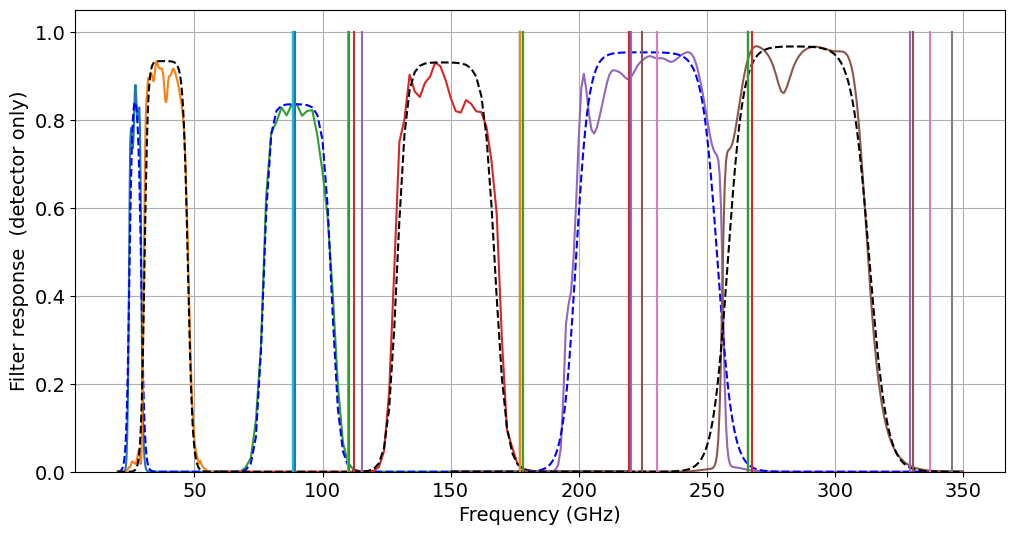

In [17]:
plt.clf()

# Note that each file has two bands
for filename in filenames:
    aaa = np.loadtxt(filename, unpack=True,comments='#')
    freqs = aaa[0]
    
    h1,c1,w1 = bandparams(freqs,aaa[1])  # Find the parameters of that real band
    model1 = bandmodel(freqs,h1,c1,w1)   # Build the model from thos parameters
    
    h2,c2,w2 = bandparams(freqs,aaa[2])
    model2 = bandmodel(freqs,h2,c2,w2)
    
    
    # plot things
    plt.plot(freqs,aaa[1])         # 'real' band
    plt.plot(freqs,model1,'--b')   # Model band
    plt.plot(freqs,aaa[2])
    plt.plot(freqs,model2,'--k')
    
    # print band parameters
    print(filename)
    print('  Band_integral 1: {0:6.2e}'.format(h1))
    print('  Band_integral 2: {0:6.2e}'.format(h2))
    print('  Low  (height, integral, center, width): {0:6.2f} , {1:6.2f} , {2:6.2f}, {3:6.2f}'.format(np.max(model1),c1,w1,h1))
    print('  High (height, integral, center, width): {0:6.2f} , {1:6.2f} , {2:6.2f}, {3:6.2f}'.format(np.max(model2),c2,w2,h2))
    print('')
    
for ff in lines:
    plt.plot([ff,ff],[0,1])

plt.ylim(0,1.05)
#plt.xlim(220,340)
#
plt.plot(150,30)
plt.xlabel('Frequency (GHz)')
plt.ylabel('Filter response  (detector only)')
plt.grid()

The model band wings look pretty good in the plot above except in the 220/280 crossover region (where those bands are interacting) and, to a lesser extent, at the low end of the 220 band which appears to have less of a wing than other edges.

# Plot the bands on top of atmospheric spectra

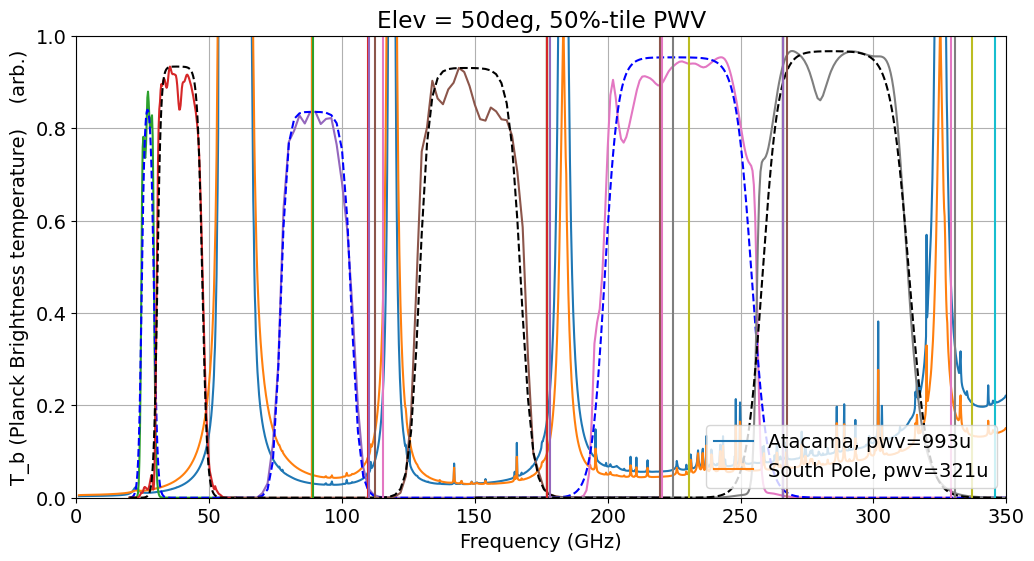

In [18]:
bc_root_dir = "/Users/ruhl/code/BoloCalc/"

# read in corrected atm file
atmfile_new = bc_root_dir + "src/atm_20201217.hdf5"
hf_new = hp.File(atmfile_new, "r")
Pole_atm400_50=hf_new["Pole"]["400,50"] # first number is PWV, second is observing elevation.
Pole_atm300_50=hf_new["Pole"]["300,50"]
freq = Pole_atm400_50[0]
Tb_321 = Pole_atm300_50[1] + 0.21*(Pole_atm400_50[1]-Pole_atm300_50[1])

Atacama_atm900_50=hf_new["Atacama"]["900,50"] # first number is PWV, second is observing elevation.
Atacama_atm1000_50=hf_new["Atacama"]["1000,50"]
Tb_993 = Atacama_atm900_50[1] + 0.93*(Atacama_atm1000_50[1]-Atacama_atm900_50[1])

plt.clf()
#plt.plot(Pole_atm400_50[0],Pole_atm400_50[2],'g',label='Pole, 400u')
#plt.plot(Pole_atm300_50[0],Pole_atm300_50[2],'g',label='Pole, 300u')
#plt.plot(freq,Atacama_atm900_50[2],label='Atacama, 900u')
#plt.plot(freq,Atacama_atm1000_50[2],label='Atacama, 1000u')

plt.plot(freq,Tb_993,label='Atacama, pwv=993u')
plt.plot(freq,Tb_321,label='South Pole, pwv=321u')

for filename in filenames:
    aaa = np.loadtxt(filename, unpack=True,comments='#')
    freqs = aaa[0]
    h1,c1,w1 = bandparams(freqs,aaa[1])
    model1 = bandmodel(freqs,h1,c1,w1)
    h2,c2,w2 = bandparams(freqs,aaa[2])
    model2 = bandmodel(freqs,h2,c2,w2)
    plt.plot(freqs,aaa[1])
    plt.plot(freqs,model1,'--b')
    plt.plot(freqs,aaa[2])
    plt.plot(freqs,model2,'--k')
    
for ff in lines:
    plt.plot([ff,ff],[0,1])
    
plt.xlabel("Frequency (GHz)")
plt.ylabel('T_b (Planck Brightness temperature)    (arb.)')
plt.xlim([0,350])
plt.ylim([0,1])
plt.title('Elev = 50deg, 50%-tile PWV')
plt.legend(loc='lower right')
plt.grid()

# Plot the bands on top of 'water-vapor only' spectra

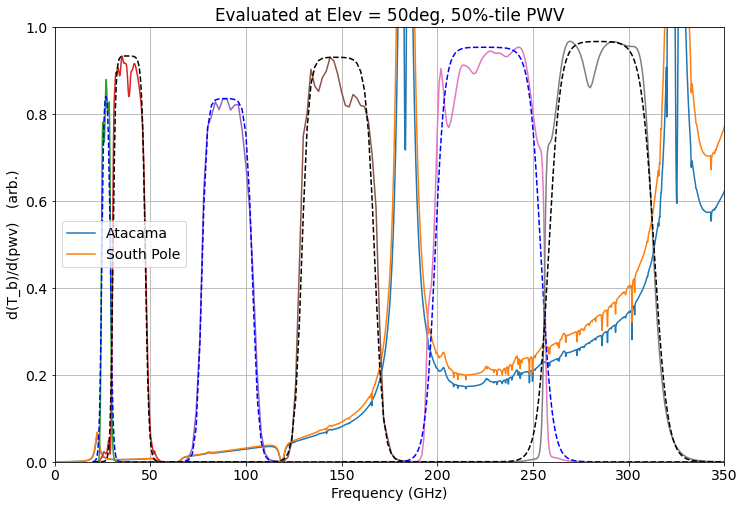

In [9]:
bc_root_dir = "/Users/ruhl/code/BoloCalc/"

# read in corrected atm file
atmfile_new = bc_root_dir + "src/atm_20201217.hdf5"
hf_new = hp.File(atmfile_new, "r")
Pole_atm400_50=hf_new["Atacama"]["400,50"] # first number is PWV, second is observing elevation.
Pole_atm300_50=hf_new["Atacama"]["300,50"]
freq_atm = Pole_atm400_50[0]
dTb_Pole = (Pole_atm400_50[2]-Pole_atm300_50[2])

Atacama_atm900_50=hf_new["Atacama"]["900,50"] # first number is PWV, second is observing elevation.
Atacama_atm1000_50=hf_new["Atacama"]["1000,50"]
dTb_Atacama = (Atacama_atm1000_50[2]-Atacama_atm900_50[2])

plt.clf()

plt.plot(freq_atm,dTb_Atacama/6,label='Atacama')
plt.plot(freq_atm,dTb_Pole/6,label='South Pole')

for filename in filenames:
    aaa = np.loadtxt(filename, unpack=True,comments='#')
    freqs = aaa[0]
    #
    f_band = aaa[1]
    h1,c1,w1 = bandparams(freqs,f_band)
    model1 = bandmodel(freqs,h1,c1,w1)
    plt.plot(freqs,f_band)
    plt.plot(freqs,model1,'--b')
    #
    f_band = aaa[2]
    h2,c2,w2 = bandparams(freqs,f_band)
    model2 = bandmodel(freqs,h2,c2,w2)
    plt.plot(freqs,f_band)
    plt.plot(freqs,model2,'--k')

plt.xlabel("Frequency (GHz)")
plt.ylabel('d(T_b)/d(pwv)   (arb.)')
plt.xlim([0,350])
plt.ylim([0,1])
plt.title('Evaluated at Elev = 50deg, 50%-tile PWV')
plt.legend()
plt.grid()

# Multiply the bands and H20 spectra, and integrate

Band  0: fancy = 9.40e-01, logistic=9.96e-01
Band  1: fancy = 2.06e+00, logistic=2.05e+00
Band  2: fancy = 1.60e+00, logistic=1.61e+00
Band  3: fancy = 9.42e+00, logistic=9.29e+00
Band  4: fancy = 1.23e+02, logistic=1.23e+02
Band  5: fancy = 2.03e+02, logistic=2.04e+02


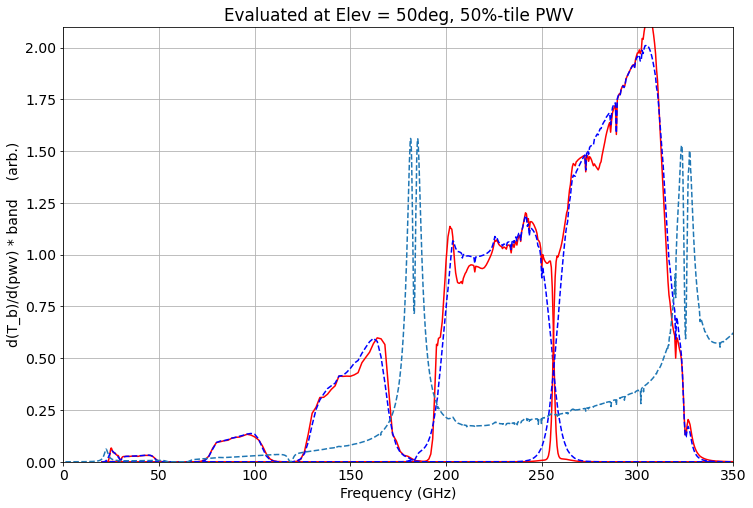

In [8]:
## bc_root_dir = "/Users/ruhl/code/BoloCalc/"

# read in corrected atm file
atmfile_new = bc_root_dir + "src/atm_20201217.hdf5"
hf_new = hp.File(atmfile_new, "r")
Pole_atm400_50=hf_new["Pole"]["400,50"] # first number is PWV, second is observing elevation.
Pole_atm300_50=hf_new["Pole"]["300,50"]
freq_atm = Pole_atm400_50[0]
dTb_Pole = (Pole_atm400_50[2]-Pole_atm300_50[2])

Atacama_atm900_50=hf_new["Atacama"]["900,50"] # first number is PWV, second is observing elevation.
Atacama_atm1000_50=hf_new["Atacama"]["1000,50"]
dTb_Atacama = (Atacama_atm1000_50[2]-Atacama_atm900_50[2])

###############
# Choose which site here.
dTb = dTb_Atacama

plt.clf()

#plt.plot(freq_atm,dTb_Atacama/6,label='Atacama')
#plt.plot(freq_atm,dTb_Pole/6,label='South Pole')

ii=0
for filename in filenames:
    aaa = np.loadtxt(filename, unpack=True,comments='#')
    freqs = aaa[0]
    #
    f_band = aaa[1]
    h1,c1,w1 = bandparams(freqs,f_band)
    model1 = bandmodel(freqs,h1,c1,w1)
    atmos_inband = np.interp(freqs,freq_atm,dTb)
    #
    bandxatmos = f_band*atmos_inband
    modelxatmos = model1*atmos_inband
    print('Band {0:2d}: fancy = {1:3.2e}, logistic={2:3.2e}'.format(ii,np.sum(bandxatmos),np.sum(modelxatmos)))
    plt.plot(freqs,bandxatmos,'r')
    plt.plot(freqs,modelxatmos,'--b')
    ii=ii+1
    #
    f_band = aaa[2]
    h2,c2,w2 = bandparams(freqs,f_band)
    model2 = bandmodel(freqs,h2,c2,w2)
    atmos_inband = np.interp(freqs,freq_atm,dTb)
    #
    bandxatmos = f_band*atmos_inband
    modelxatmos = model2*atmos_inband
    print('Band {0:2d}: fancy = {1:3.2e}, logistic={2:3.2e}'.format(ii,np.sum(bandxatmos),np.sum(modelxatmos)))
    plt.plot(freqs,bandxatmos,'r')
    plt.plot(freqs,modelxatmos,'--b')
    ii=ii+1
    
plt.xlabel("Frequency (GHz)")
plt.ylabel('d(T_b)/d(pwv) * band    (arb.)')
plt.xlim([0,350])
plt.ylim([0,2.1])
plt.title('Evaluated at Elev = 50deg, 50%-tile PWV')

plt.plot(freq_atm,dTb_Atacama/6,'--')
#plt.plot(freq_atm,dTb_Pole/6,label='South Pole')
plt.grid()